<a href="https://colab.research.google.com/github/andreiamferreira/processamento-imagens-ocr-tcc/blob/main/pipeline_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!apt-get install -y tesseract-ocr
!pip install pytesseract opencv-python-headless
!pip install python-Levenshtein

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.9 MB/s eta 0:00:00


In [4]:
from PIL import Image, ImageOps
import numpy as np
import cv2
import pytesseract
from collections import Counter
import string
from sklearn.metrics import mean_squared_error
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
import os
import matplotlib.pyplot as plt
import pandas as pd
import Levenshtein

pasta_imagens = '/content/gdrive/MyDrive/tcc/imagens_dataset/imagens/listas_isoladas'
csv_transcricoes = '/content/gdrive/MyDrive/tcc/imagens_dataset/imagens/rotulos.csv'


Calcula MSE

In [5]:
def calcula_mse(imagem_original, imagem_processada):
    imagem_original_float32 = imagem_original.astype(np.float32)
    imagem_processada_float32 = imagem_processada.astype(np.float32)
    return mean_squared_error(imagem_original, imagem_processada)

Calcula PSNR

In [6]:
def calcula_psnr(imagem_original, imagem_processada):
    mse = calcula_mse(imagem_original, imagem_processada)
    if mse == 0:
        return float('inf')   # se o mse for 0 exato, significa que as duas imagens são a mesma, logo, psnr = infinito
    pixel_maximo = 255.0
    psnr = 20 * np.log10(pixel_maximo / np.sqrt(mse))
    return psnr

Calcula SSIM

In [7]:
def calcula_ssim(imagem_original, imagem_processada):
    ssim_score, dif = ssim(imagem_original, imagem_processada, full=True)
    return ssim_score

Calcula MAE

In [8]:
def calcula_mae(imagem_original, imagem_processada):
    imagem_original_float32 = imagem_original.astype(np.float32)
    imagem_processada_float32 = imagem_processada.astype(np.float32)
    return np.mean(np.abs(imagem_original_float32 - imagem_processada_float32))

Calcula RMSE

In [9]:
def calcula_rmse(imagem_original, imagem_processada):
    return np.sqrt(calcula_mse(imagem_original, imagem_processada))

Função para redimensionar a imagem para otimizar o processamento do OCR

In [10]:
def redimensionar_imagem(imagem):
    maxima_dimensao_pixels = 1600
    altura, largura = imagem.shape[:2]
    if max(altura, largura) > maxima_dimensao_pixels:
        if altura > largura:
            nova_altura = maxima_dimensao_pixels
            nova_largura = int(largura * (nova_altura / altura))
        else:
            nova_largura = maxima_dimensao_pixels
            nova_altura = int(altura * (nova_largura / largura))

        imagem_redimensionada = cv2.resize(imagem, (nova_largura, nova_altura), interpolation=cv2.INTER_LANCZOS4)
        return imagem_redimensionada
    return imagem

Calculos de acurácia de texto

In [11]:
def calcular_similiaridade(texto, resultado_ocr):
    texto_original_normalizado = "".join(filter(str.isalnum, texto.lower()))
    resultado_ocr_normalizado = "".join(filter(str.isalnum, resultado_ocr.lower()))

    if not texto_original_normalizado and not resultado_ocr_normalizado:
        return 1.0
    if not texto_original_normalizado or not resultado_ocr_normalizado:
        return 0.0

    distancia_levenshtein = Levenshtein.distance(texto_original_normalizado, resultado_ocr_normalizado)
    acuracia = 1 - (distancia_levenshtein / max(len(texto_original_normalizado), len(resultado_ocr_normalizado)))

    return acuracia

In [12]:
def verificar_imagem_escura(rgb):
    r, g, b = rgb
    brilho = (int(r)*299 + int(g)*587 + int(b)*114) / 1000
    return brilho < 100

In [13]:
def verificar_cor_predominante(imagem_bgr):
    imagem_reduzida = cv2.resize(imagem_bgr, (50, 50))
    pixels = imagem_reduzida.reshape(-1, 3)
    pixels_rgb = [tuple(map(int, pixel[::-1])) for pixel in pixels] # pixel[::-1] converte BGR para RGB
    cor = Counter(pixels_rgb).most_common(1)[0][0]

    print(f"Cor de fundo dominante (R,G,B): {cor}")
    return cor

def calcular_saturacao(cor):
    cor_predominante_np = np.uint8([[cor]])
    cor_predominante_hsv = cv2.cvtColor(cor_predominante_np, cv2.COLOR_RGB2HSV)[0][0]
    return cor_predominante_hsv[1]


In [14]:
def normalizar_texto(texto):
    return texto.translate(str.maketrans("", "", string.punctuation)).strip().lower()


In [15]:
def exibir_tabela_resultados(resultados):
    df = pd.DataFrame(resultados)
    df_ordem_crescente = df.sort_values(by='acuracia_ocr', ascending=False)

    print("\n" + "="*120)
    print(" " * 45 + "RELATÓRIO DE ACURÁCIA E QUALIDADE DE IMAGEM OCR")
    print("="*120)

    print(df_ordem_crescente[[
        'nome_arquivo',
        'acuracia_ocr',
        'mse',
        'psnr',
        'ssim',
        'mae',
        'rmse'
    ]].to_string(index=False))
    print("="*120)

    if not df.empty:
        media_acuracia_geral = df['acuracia_ocr'].mean()
        print(f"Média geral: {media_acuracia_geral:.2f}%")
    else:
        print("Não há resultados para cálculo.")
    print("="*120)


CSV de transcrições carregado com sucesso de: /content/gdrive/MyDrive/tcc/imagens_dataset/imagens/rotulos.csv

 Imagem: pizza_1_lista.jpg
Descrição de referência (CSV): 'Ingredientes Massa: Farinha de trigo e milho, sal, ovos, fermento biológico. Recheio: Queijo mussarela, linguiça calabresa, molho de tomate, requeijão. CONTÉM GLÚTEN CONTÉM LACTOSE ALÉRGICOS: CONTÉM DERIVADOS DE TRIGO, LEITE E SOJA.'
Cor de fundo dominante (R,G,B): (93, 86, 78)
Fundo colorido escuro detectado. Aplica CLAHE, inversão e binarização


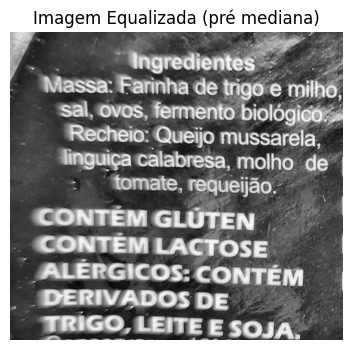

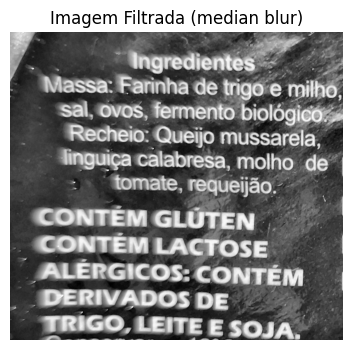

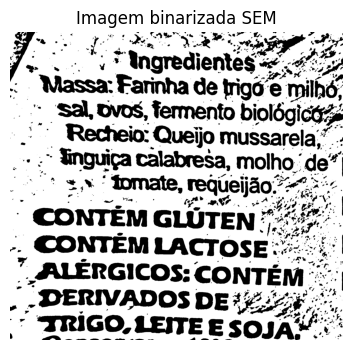

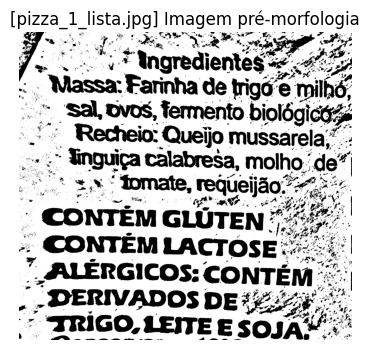

Dilatação com kernel (8, 8)
Fechamento com kernel (8, 8)
Erosão para abertura com kernel (8, 8)
Abertura com kernel (8, 8)
Mean Squared Error (MSE): 28249.66
Peak Signal-to-Noise Ratio (PSNR): 3.62 dB
Structural Similarity Index (SSIM): 0.3312
Mean Absolute Error (MAE): 164.93
Root Mean Squared Error (RMSE): 168.08
Acurácia do OCR - Levenshtein: 0.7926


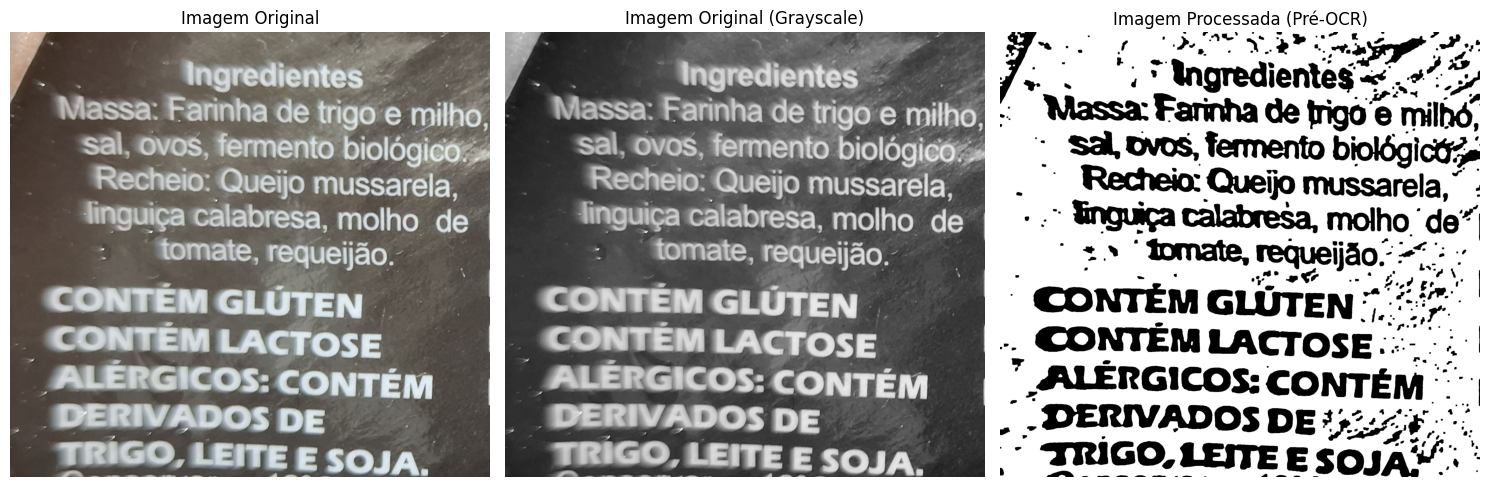


--- Texto Completo Lido pelo OCR ---
w oof pe OT V2 ea PP.
7. . '. Wngredientes Oy
. Massa: Farinha de frigoe milhd,
Sal, vos, fermento biolégict.
. \ Recheio: Queijo mussarela, -
 . linguiga calabresa, molho 'de
' t.8 tomate, requeljao. 2

- CONTEM GLUTEN 77.27.
-- CONTEMLACTOSE::.
 ALERGICOS: CONTEM
, -DERIVADOS DE 92354'
 IJRIGO, LEITE ESOJA':: :

----------------------------------------

 Imagem: leite_lista.jpg
Descrição de referência (CSV): 'INGREDIENTES: Leite em pó integral. NÃO CONTÉM GLÚTEN. ALÉRGICOS: CONTÉM LEITE. CONTÉM LACTOSE.'
Cor de fundo dominante (R,G,B): (195, 198, 205)
Fundo claro detectado. Aplica grayscale normal.
Mean Squared Error (MSE): 0.00
Peak Signal-to-Noise Ratio (PSNR): inf dB
Structural Similarity Index (SSIM): 1.0000
Mean Absolute Error (MAE): 0.00
Root Mean Squared Error (RMSE): 0.00
Acurácia do OCR - Levenshtein: 0.3506


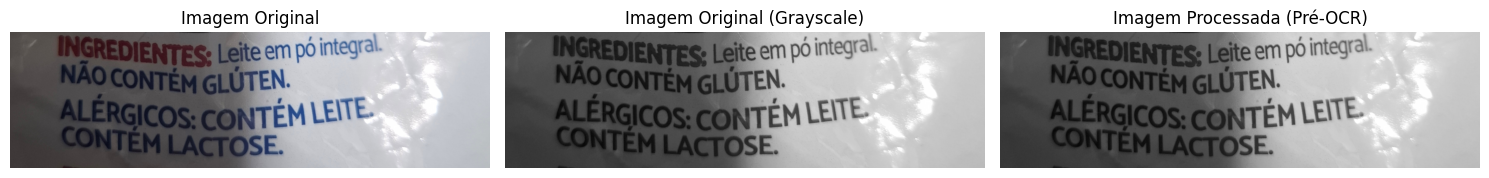


--- Texto Completo Lido pelo OCR ---
ite em po integral.
TEN.

ITEM LEITE-
SE.

----------------------------------------

 Imagem: rosquinhas_sabor_chocolate_lista.jpg
Descrição de referência (CSV): 'INGREDIENTES: FARINHA DE TRIGO ENRIQUECIDA COM FERRO E ÁCIDO FÓLICO, AÇÚCAR, GORDURA VEGETAL, AMIDO DE MILHO*, AÇÚCAR INVERTIDO, CACAU EM PÓ, SAL, CORANTE DE CARAMELO (INS 160d), FERMENTOS QUÍMICOS: BICARBONATO DE AMÔNIO (INS 503ii), SÓDIO (INS 500ii) E PIROFOSFATO ÁCIDO DE SÓDIO (INS 450i), AROMATIZANTES E EMULSIFICANTE: LECITINA DE SOJA* (INS 322). CONTÉM GLÚTEN. NÃO CONTÉM LACTOSE. ALÉRGICOS: CONTÉM DERIVADO DE TRIGO E SOJA.'
Cor de fundo dominante (R,G,B): (184, 160, 158)
Fundo claro detectado. Aplica grayscale normal.
Mean Squared Error (MSE): 0.00
Peak Signal-to-Noise Ratio (PSNR): inf dB
Structural Similarity Index (SSIM): 1.0000
Mean Absolute Error (MAE): 0.00
Root Mean Squared Error (RMSE): 0.00
Acurácia do OCR - Levenshtein: 0.7337


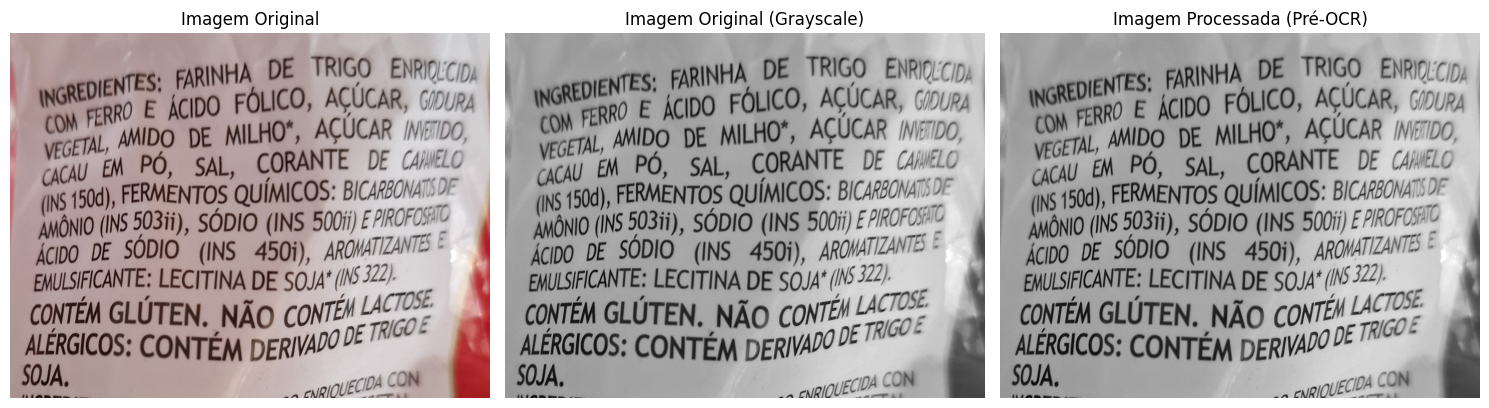


--- Texto Completo Lido pelo OCR ---
EpIENTES: FARINHA DE TRIGO ENRINCp,
. erro E ACIDO FOLICO, ACUCAR, GiDuRu
veceTAL, AMIDO DE MILHO, ACUCAR IiED0
cca EM PO, SAL, CORANTE DE Cajiic
ins 150d), FERMENTOS QUIMICOS: BICAREONA. 7
AMONIO (INS 50341), SODIO (INS 500ii) FPIROFO
kci0 DE SODIO (INS 450i), AROVATIZANTE -
EMULSIFICANTE: LECITINA DE SOJA (NS 322)

CONTEM GLUTEN. NAO CONTEH LACT:
SUA GICOS: CONTEM DERNAIOZ
oa . pI WECIDA ON

----------------------------------------

 Imagem: cha_1_lista.jpg
Descrição de referência (CSV): 'Ingredientes Folhas e Talos de Chá Verde (Camelia sinensis) NÃO CONTÉM GLÚTEN.'
Cor de fundo dominante (R,G,B): (160, 160, 162)
Fundo claro detectado. Aplica grayscale normal.
Mean Squared Error (MSE): 0.00
Peak Signal-to-Noise Ratio (PSNR): inf dB
Structural Similarity Index (SSIM): 1.0000
Mean Absolute Error (MAE): 0.00
Root Mean Squared Error (RMSE): 0.00
Acurácia do OCR - Levenshtein: 0.1406


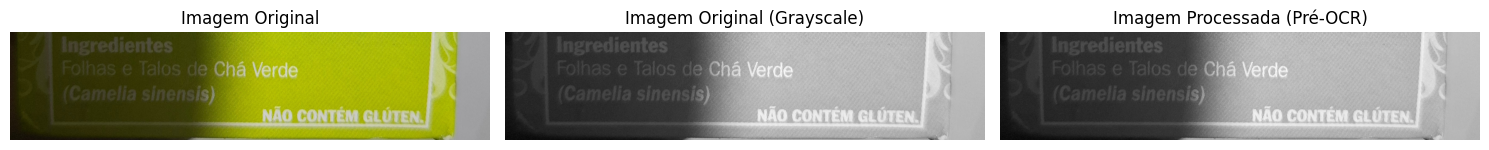


--- Texto Completo Lido pelo OCR ---
Maier
Bae
a
UE
Be AN

----------------------------------------

 Imagem: manteiga_1_lista.jpg
Descrição de referência (CSV): 'INGREDIENTES: CREME DE LEITE PASTEURIZADO E FERMENTOS LÁTICOS. ALÉRGICOS: CONTÉM DERIVADOS DE LEITE. CONTÉM LACTOSE. NÃO CONTÉM GLÚTEN.'
Cor de fundo dominante (R,G,B): (146, 152, 150)
Fundo claro detectado. Aplica grayscale normal.
Mean Squared Error (MSE): 0.00
Peak Signal-to-Noise Ratio (PSNR): inf dB
Structural Similarity Index (SSIM): 1.0000
Mean Absolute Error (MAE): 0.00
Root Mean Squared Error (RMSE): 0.00
Acurácia do OCR - Levenshtein: 0.0982


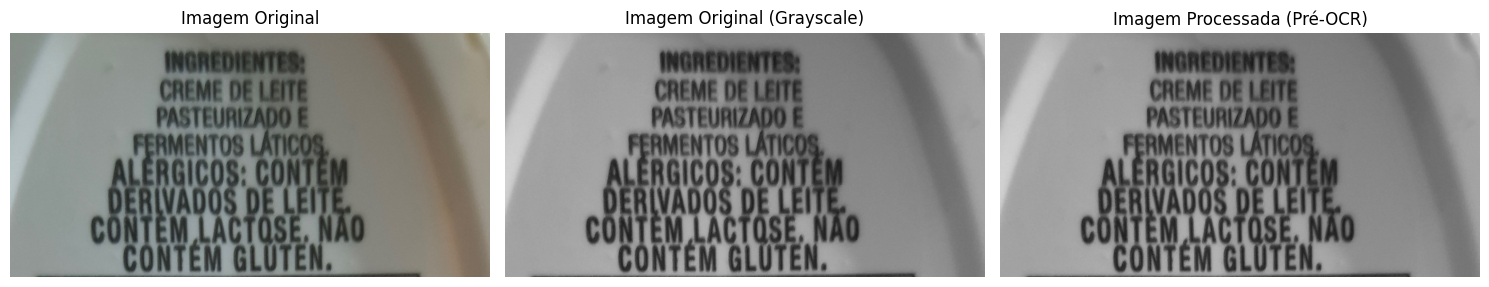


--- Texto Completo Lido pelo OCR ---
see,
NTE GLUTEN,

----------------------------------------

 Imagem: farinha_1_lista.jpg
Descrição de referência (CSV): 'Ingredientes: fubá de milho*, ferro e ácido fólico. *Ingredientes contendo genes de Agrobacterium tumefaciens, Bacillus thuringiensis, Streptomyces viridochromogenes e Zea mays. ALÉRGICOS: PODE CONTER TRIGO, CEVADA E SOJA. CONTÉM GLÚTEN. Produto naturalmente sem glúten e produzido em local onde são processados alimentos com glúten. '
Cor de fundo dominante (R,G,B): (175, 154, 47)
Fundo claro detectado. Aplica grayscale normal.
Mean Squared Error (MSE): 0.00
Peak Signal-to-Noise Ratio (PSNR): inf dB
Structural Similarity Index (SSIM): 1.0000
Mean Absolute Error (MAE): 0.00
Root Mean Squared Error (RMSE): 0.00
Acurácia do OCR - Levenshtein: 0.8845


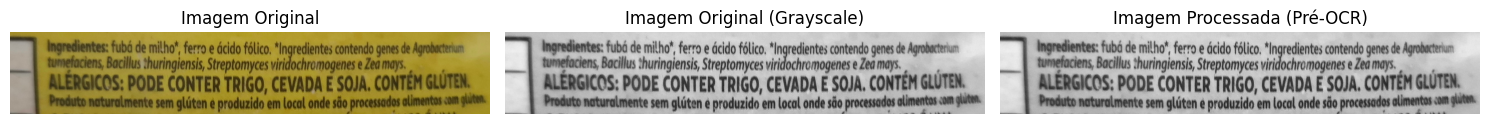


--- Texto Completo Lido pelo OCR ---
Ingredientes: fubd de milho, ferro e dcido folico. Ingredientes contendo genes de Agrobacterium
 temefaciens, Bacillus thuringiensis, Streptomyces Hes ito e lea mays,

ALERGICOS: PODE CONTER TRIGO, CEVADA E SOJA, CONTEM GLUTEN.
 Produtto naturalmente sem gliten  produzido em local onde stio processadas alimentos com gute

----------------------------------------

 Imagem: catupiry_1_lista.jpg
Descrição de referência (CSV): 'INGREDIENTES: CREME DE LEITE, MASSA COALHADA (LEITE FLUIDO A GRANEL DE USO INDUSTRIAL DESNATADO E ACIDULANTE ÁCIDO LÁTICO), CLORETO DE SÓDIO (SAL), ESTABILIZANTES: HEXAMETAFOSFATO DE SÓDIO, PIROFOSFATO TETRASSÓDICO, FOSFATO TRISSÓDICO E CONSERVADOR SORBATO DE POTÁSSIO. ALÉRGICOS: CONTÉM DERIVADOS DE LEITE. CONTÉM LACTOSE. NÃO CONTÉM GLÚTEN.'
Cor de fundo dominante (R,G,B): (126, 25, 29)
Fundo colorido escuro detectado. Aplica CLAHE, inversão e binarização


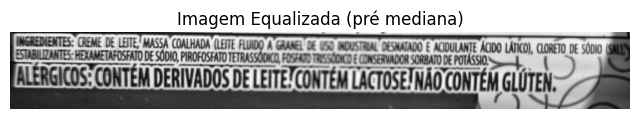

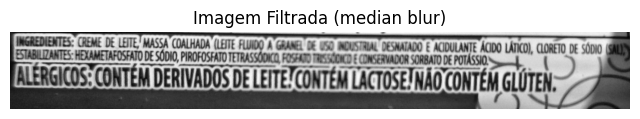

In [ ]:
try:
    df_transcricoes = pd.read_csv(csv_transcricoes, sep=";")
    df_transcricoes['nome_arquivo_lista_separada'] = df_transcricoes['nome_arquivo_lista_separada'].str.lower()
    print(f"CSV de transcrições carregado com sucesso de: {csv_transcricoes}")
except FileNotFoundError:
    print(f"Arquivo CSV não encontrado")
except KeyError:
    print("Colunas 'nome_arquivo_lista_separada' e 'lista_ingredientes_sem_avisos' não encontradas.")


imagens = [f for f in os.listdir(pasta_imagens) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

resultados = []

if not imagens:
    print(f"Nenhuma imagem encontrada na pasta: {pasta_imagens}")
else:
    for imagem in imagens:
        caminho_imagem = os.path.join(pasta_imagens, imagem)
        print(f"\n Imagem: {imagem}")

        descricao_original = "Não encontrado no CSV"
        coluna = df_transcricoes[df_transcricoes['nome_arquivo_lista_separada'] == imagem.lower()]
        if not coluna.empty:
            descricao_original = coluna['lista_ingredientes_com_avisos'].iloc[0]
            print(f"Descrição de referência (CSV): '{descricao_original}'")

        try:
            rotulo = Image.open(caminho_imagem)
            rotulo = ImageOps.exif_transpose(rotulo) # ajusta a orientação da imagem, se necessário
            imagem_bgr = cv2.cvtColor(np.array(rotulo), cv2.COLOR_RGB2BGR)
            imagem_em_escala_cinzas = cv2.cvtColor(imagem_bgr, cv2.COLOR_BGR2GRAY)

            cor_predominante = verificar_cor_predominante(imagem_bgr)
            saturacao = calcular_saturacao(cor_predominante)
            limiar_saturacao = 30

            imagem_processada = imagem_em_escala_cinzas

            if verificar_imagem_escura(cor_predominante):
                if saturacao < limiar_saturacao:
                    print("Fundo preto/cinza detectado (escuro e baixa saturação). Nenhuma operação necessária")
                else:
                    print("Fundo colorido escuro detectado. Aplica CLAHE, inversão e binarização")
                    clahe_clip_limit = 2.0
                    clahe_tile_grid_size = (8, 8)

                    clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=clahe_tile_grid_size)
                    gray_clahe = clahe.apply(imagem_em_escala_cinzas)

                    kernel_mediana = 7
                    gray_clahe_filtrada = cv2.medianBlur(gray_clahe, kernel_mediana)

                    plt.figure(figsize=(8, 4))
                    plt.imshow(gray_clahe, cmap='gray')
                    plt.title('Imagem Equalizada (pré mediana)')
                    plt.axis('off')
                    plt.show()

                    plt.figure(figsize=(8, 4))
                    plt.imshow(gray_clahe_filtrada, cmap='gray')
                    plt.title('Imagem Filtrada (median blur)')
                    plt.axis('off')
                    plt.show()

                    imagem_invertida = 255 - gray_clahe_filtrada
                    teste = 255 - gray_clahe

                    dimensao_minima_imagem = min(imagem_em_escala_cinzas.shape)
                    adaptive_block_size = int(dimensao_minima_imagem * 0.05)
                    if adaptive_block_size % 2 == 0:
                        adaptive_block_size += 1
                    if adaptive_block_size < 3:
                        adaptive_block_size = 3

                    imagem_binarizada = cv2.adaptiveThreshold(imagem_invertida, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, adaptive_block_size, 10)

                    binario_comparativo = cv2.adaptiveThreshold(teste, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, adaptive_block_size, 10)

                    plt.figure(figsize=(8, 4))
                    plt.imshow(imagem_binarizada, cmap='gray')
                    plt.title('Imagem binarizada SEM')
                    plt.axis('off')
                    plt.show()


                    plt.figure(figsize=(8, 4))
                    plt.imshow(binario_comparativo, cmap='gray')
                    plt.title(f'[{imagem}] Imagem pré-morfologia')
                    plt.axis('off')
                    plt.show()

                    N = 8
                    kernel_nxn = cv2.getStructuringElement(cv2.MORPH_RECT, (N, N))

                    #dlatação seguida de rosão

                    imagem_apos_dilatacao = cv2.dilate(imagem_binarizada, kernel_nxn)
                    print(f"Dilatação com kernel {kernel_nxn.shape}")

                    imagem_apos_fechamento = cv2.erode(imagem_apos_dilatacao, kernel_nxn)
                    print(f"Fechamento com kernel {kernel_nxn.shape}")

                    # erosa seguida por dilatacao
                    imagem_apos_erosao_para_abertura = cv2.erode(imagem_apos_fechamento, kernel_nxn)
                    print(f"Erosão para abertura com kernel {kernel_nxn.shape}")

                    imagem_apos_abertura = cv2.dilate(imagem_apos_erosao_para_abertura, kernel_nxn)
                    print(f"Abertura com kernel {kernel_nxn.shape}")

                    imagem_processada = imagem_apos_abertura


            else:
                print("Fundo claro detectado. Aplica grayscale normal.")

            if imagem_em_escala_cinzas.shape != imagem_processada.shape:
                imagem_processada_final = cv2.resize(imagem_processada, (imagem_em_escala_cinzas.shape[1], imagem_em_escala_cinzas.shape[0]))
            else:
                imagem_processada_final = imagem_processada

            valor_mse = calcula_mse(imagem_em_escala_cinzas, imagem_processada_final)
            print(f"Mean Squared Error (MSE): {valor_mse:.2f}")

            valor_psnr = calcula_psnr(imagem_em_escala_cinzas, imagem_processada_final)
            print(f"Peak Signal-to-Noise Ratio (PSNR): {valor_psnr:.2f} dB")

            valor_ssim = calcula_ssim(imagem_em_escala_cinzas, imagem_processada_final)
            print(f"Structural Similarity Index (SSIM): {valor_ssim:.4f}")

            valor_mae = calcula_mae(imagem_em_escala_cinzas, imagem_processada_final)
            print(f"Mean Absolute Error (MAE): {valor_mae:.2f}")

            valor_rmse = calcula_rmse(imagem_em_escala_cinzas, imagem_processada_final)
            print(f"Root Mean Squared Error (RMSE): {valor_rmse:.2f}")

            imagem_redimensionada_ocr = redimensionar_imagem(imagem_processada_final)

            custom_config = r'--oem 1 --psm 6 -c tessedit_char_whitelist="1234567890ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzáÁéÉíÍóÓúÚãÃõÕâÂêÊôÔç.:,!()-\' "'
            texto_ocr = pytesseract.image_to_string(imagem_redimensionada_ocr, config=custom_config)

            resultado_ocr = normalizar_texto(texto_ocr)

            acuracia = 0.0
            if descricao_original != "Não encontrado no CSV":
                acuracia = calcular_similiaridade(descricao_original, resultado_ocr)
                print(f"Acurácia do OCR - Levenshtein: {acuracia:.4f}")
            else:
                print("descrição de referência não encontrada.")

            resultados.append({
                'nome_arquivo': imagem,
                'texto_ocr': resultado_ocr,
                'descricao_csv': descricao_original,
                'acuracia_ocr': acuracia,
                'mse': valor_mse,
                'psnr': valor_psnr,
                'ssim': valor_ssim,
                'mae': valor_mae,
                'rmse': valor_rmse
            })

            plt.figure(figsize=(15, 7))

            plt.subplot(1, 3, 1)
            plt.imshow(rotulo, cmap='gray')
            plt.title('Imagem Original')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(imagem_em_escala_cinzas, cmap='gray')
            plt.title('Imagem Original (Grayscale)')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(imagem_processada_final, cmap='gray')
            plt.title('Imagem Processada (Pré-OCR)')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            print("\n--- Texto Completo Lido pelo OCR ---")
            print(texto_ocr)
            print("-" * 40)

        except Exception as e:
            print(f"Erro ao processar a imagem {imagem}: {e}")
            resultados.append({
                'nome_arquivo': imagem,
                'texto_ocr': "ERRO DE PROCESSAMENTO",
                'descricao_csv': descricao_original,
                'acuracia_ocr': 0.0
            })

if resultados:
  exibir_tabela_resultados(resultados)
else:
    print("\nNenhum resultado.")